In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk("./"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./all_emails.csv
./Project_4.ipynb
./model2.pth
./Recovered_Session63.py
./model1.pth
./.ipynb_checkpoints/all_emails-checkpoint.csv
./.ipynb_checkpoints/Project_4-checkpoint.ipynb
./.ipynb_checkpoints/Recovered_Session63-checkpoint.py
./og_emails/6-14msg3.txt
./og_emails/6-110msg1.txt
./og_emails/9-63msg1.txt
./og_emails/spmsga95.txt
./og_emails/6-97msg1.txt
./og_emails/8-887msg1.txt
./og_emails/spmsgb16.txt
./og_emails/6-830msg1.txt
./og_emails/9-612msg1.txt
./og_emails/spmsga161.txt
./og_emails/spmsgc135.txt
./og_emails/6-113msg2.txt
./og_emails/6-829msg3.txt
./og_emails/spmsga130.txt
./og_emails/spmsgc119.txt
./og_emails/spmsga65.txt
./og_emails/3-390msg0.txt
./og_emails/3-389msg1.txt
./og_emails/spmsgc133.txt
./og_emails/5-1318msg2.txt
./og_emails/spmsgb77.txt
./og_emails/spmsgc68.txt
./og_emails/3-378msg5.txt
./og_emails/8-840msg1.txt
./og_emails/6-1msg1.txt
./og_emails/6-68msg1.txt
./og_emails/5-1315msg2.txt
./og_emails/spmsgc37.txt
./og_emails/6-455msg1.txt
./og_emails/6-50msg0

In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
from scipy import stats
from wordcloud import WordCloud, STOPWORDS
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix

# 1. Frame the problem
Using the customer description, Define the problem your trying to solve in your own words (remember this is not technial but must be specific so the customer understands the project

Given the pre-processed emails that are classified as either spam or ham, create a machine learning system trained on this dataset of emails that can effectively predict whether or not an email is spam or ham.

# 2. Get the Data 
Define how you recieved the data (provided, gathered..)

In [3]:
dir_name = './og_emails'

all_emails = pd.DataFrame(columns=['subject', 'contents', 'subj_len', 'body_len', 'is_spam']) # initialize df with col names

# iterate through each .txt file 
for filename in os.listdir(dir_name):
    path = os.path.join(dir_name, filename)
    if os.path.isfile(path):
        with open(path, 'r') as file:
            contents = file.read() 
            text_list = contents.split('\n')
            text_list = [x for x in text_list if x]

        # extract subject line and email content 
        subj_line = text_list[0][9:] 
        email_cont = text_list[1] 
        is_spam = 1 if 'spm' in filename else 0
        
        all_emails.loc[len(all_emails)] = [subj_line, email_cont, len(subj_line), len(email_cont), is_spam]

all_emails.to_csv('all_emails.csv', index=False) # create into csv for visualization 

In [4]:
all_emails.head()

,subject,contents,subj_len,body_len,is_spam
0,wkshp : * early * - e ( = ) uralic interaction,organize combination colloquium work seminar p...,46,1917,0
1,job announcement - academium sinica,"job announcement institute history philology ,...",35,1339,0
2,knowledge language bibliography,association language awareness knowledge langu...,31,953,0
3,service update,due significant rapid policy change recently i...,14,311,1
4,job announcement,job announcement department foreign language l...,16,1218,0


# 3. Explore the Data
Gain insights into the data you have from step 2, making sure to identify any bias

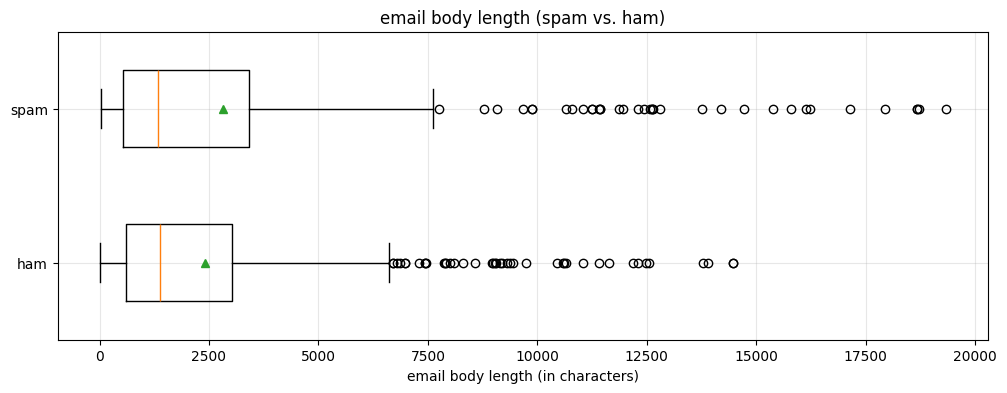

In [5]:
# analyze lengths of spam vs. ham emails (chars) 

spam_lens = all_emails[all_emails['is_spam'] == 1]['body_len']
ham_lens = all_emails[all_emails['is_spam'] == 0]['body_len'] 

plt.figure(figsize=(12, 4))
plt.boxplot([ham_lens, spam_lens], tick_labels=['ham', 'spam'], widths=.5, vert=False, showmeans=True)
plt.xlabel('email body length (in characters)')
plt.title('email body length (spam vs. ham)')
plt.grid(True, alpha=0.3)
plt.show()

# observations:
# roughly equal median, both have many outliers 
# but only spam emails have body lengths > 150000 
# which can be a good feature to add! 

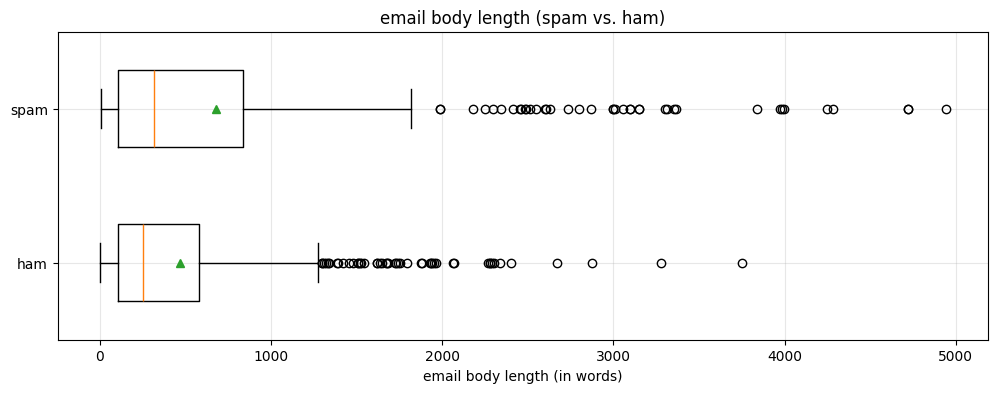

In [6]:
# analyze word count instead of char count

all_emails['word_count'] = all_emails['contents'].apply(lambda x: len(x.split()))

spam_wc = all_emails[all_emails['is_spam'] == 1]['word_count']
ham_wc = all_emails[all_emails['is_spam'] == 0]['word_count']

plt.figure(figsize=(12, 4))
plt.boxplot([ham_wc, spam_wc], tick_labels=['ham', 'spam'], widths=.5, vert=False, showmeans=True)
plt.xlabel('email body length (in words)')
plt.title('email body length (spam vs. ham)')
plt.grid(True, alpha=0.3)
plt.show()

# on average, it seems as if spam has a much greater q3-q4 range 
# and also only spam emails have word counts > 4000 
# it also seems as if there is a clustering of outliers

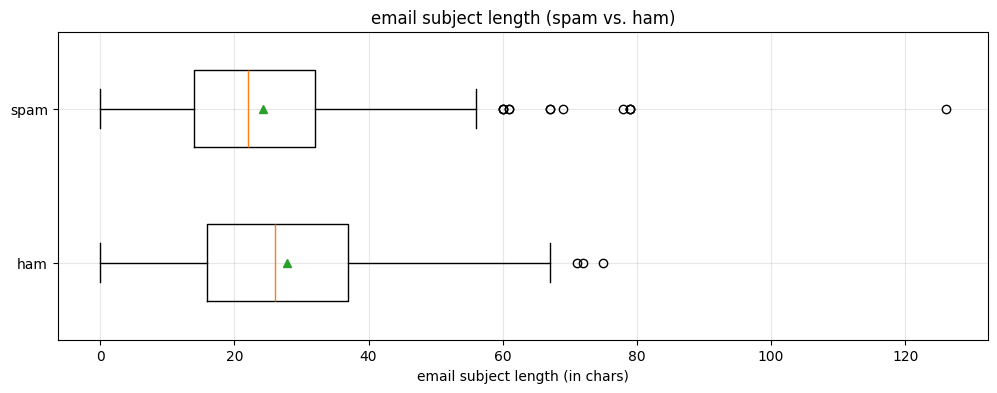

In [7]:
# analyze subject character length 

spam_sublen = all_emails[all_emails['is_spam'] == 1]['subj_len']
ham_sublen = all_emails[all_emails['is_spam'] == 0]['subj_len']

plt.figure(figsize=(12, 4))
plt.boxplot([ham_sublen, spam_sublen], tick_labels=['ham', 'spam'], widths=.5, vert=False, showmeans=True)
plt.xlabel('email subject length (in chars)')
plt.title('email subject length (spam vs. ham)')
plt.grid(True, alpha=0.3)
plt.show()

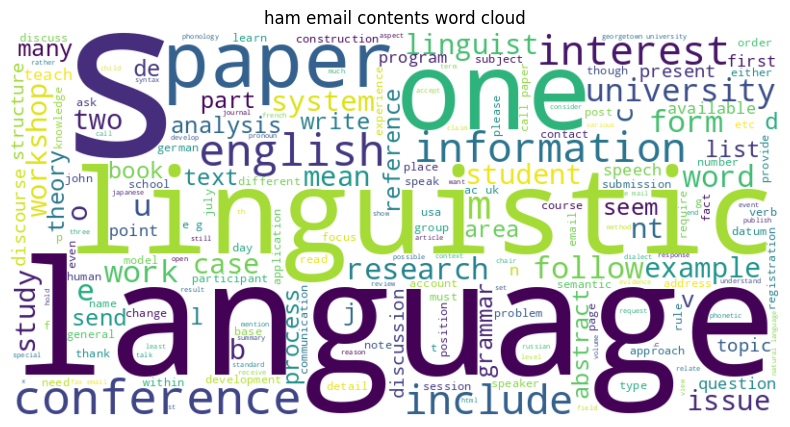

In [8]:
# make word cloud for ham email bodies

text = ' '.join(all_emails[all_emails['is_spam'] == 0]['contents'].astype(str).tolist())
text = re.sub(r'[^A-Za-z\s]', '', text)
stopwords = set(STOPWORDS)
text = ' '.join(word for word in text.split() if word not in stopwords)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('ham email contents word cloud')
plt.show()

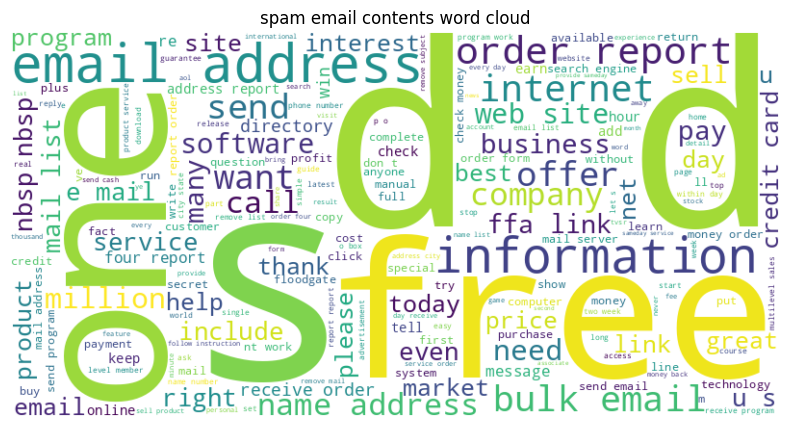

In [9]:
# word cloud for spam email bodies

text = ' '.join(all_emails[all_emails['is_spam'] == 1]['contents'].astype(str).tolist())
text = re.sub(r'[^A-Za-z\s]', '', text)
stopwords = set(STOPWORDS)
text = ' '.join(word for word in text.split() if word not in stopwords)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('spam email contents word cloud')
plt.show()

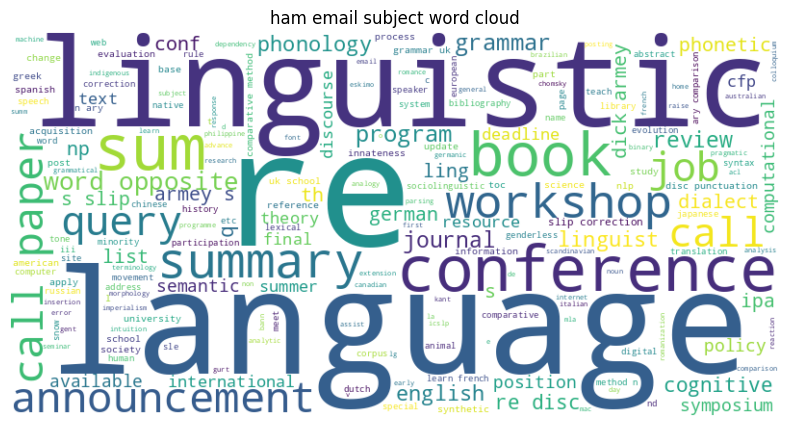

In [10]:
# word cloud for ham email subject lines

text = ' '.join(all_emails[all_emails['is_spam'] == 0]['subject'].astype(str).tolist())
text = re.sub(r'[^A-Za-z\s]', '', text)
stopwords = set(STOPWORDS)
text = ' '.join(word for word in text.split() if word not in stopwords)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('ham email subject word cloud')
plt.show()

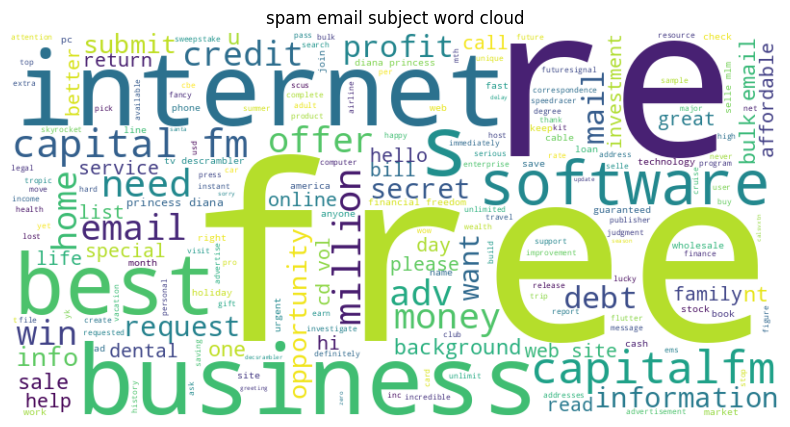

In [11]:
# word cloud for spam email subject lines

text = ' '.join(all_emails[all_emails['is_spam'] == 1]['subject'].astype(str).tolist())
text = re.sub(r'[^A-Za-z\s]', '', text)
stopwords = set(STOPWORDS)
text = ' '.join(word for word in text.split() if word not in stopwords)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('spam email subject word cloud')
plt.show()

In [12]:
all_emails['avg_word_len'] = ((all_emails['body_len'] - (all_emails['word_count'] - 1)) / all_emails['word_count']).round(2)
all_emails.head()

all_emails.to_csv('all_emails.csv', index=False)

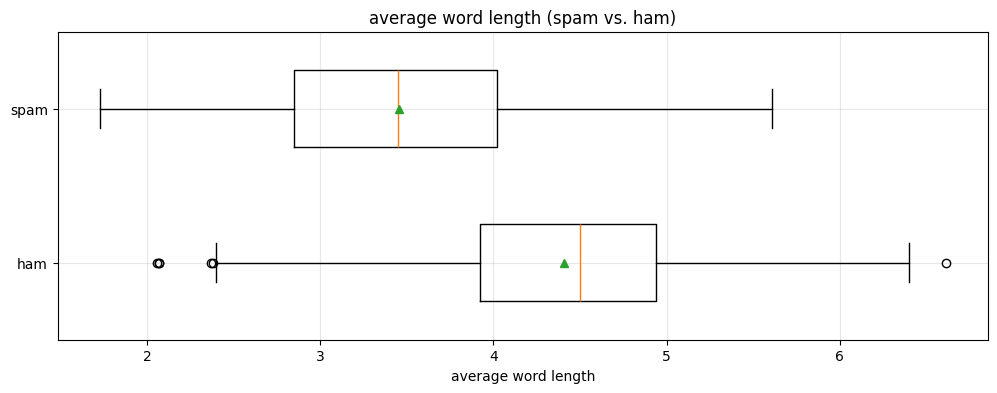

In [13]:
# analyze average word lengths of spam vs. ham

spam_lens = all_emails[all_emails['is_spam'] == 1]['avg_word_len']
ham_lens = all_emails[all_emails['is_spam'] == 0]['avg_word_len'] 

plt.figure(figsize=(12, 4))
plt.boxplot([ham_lens, spam_lens], tick_labels=['ham', 'spam'], widths=.5, vert=False, showmeans=True)
plt.xlabel('average word length')
plt.title('average word length (spam vs. ham)')
plt.grid(True, alpha=0.3)
plt.show()

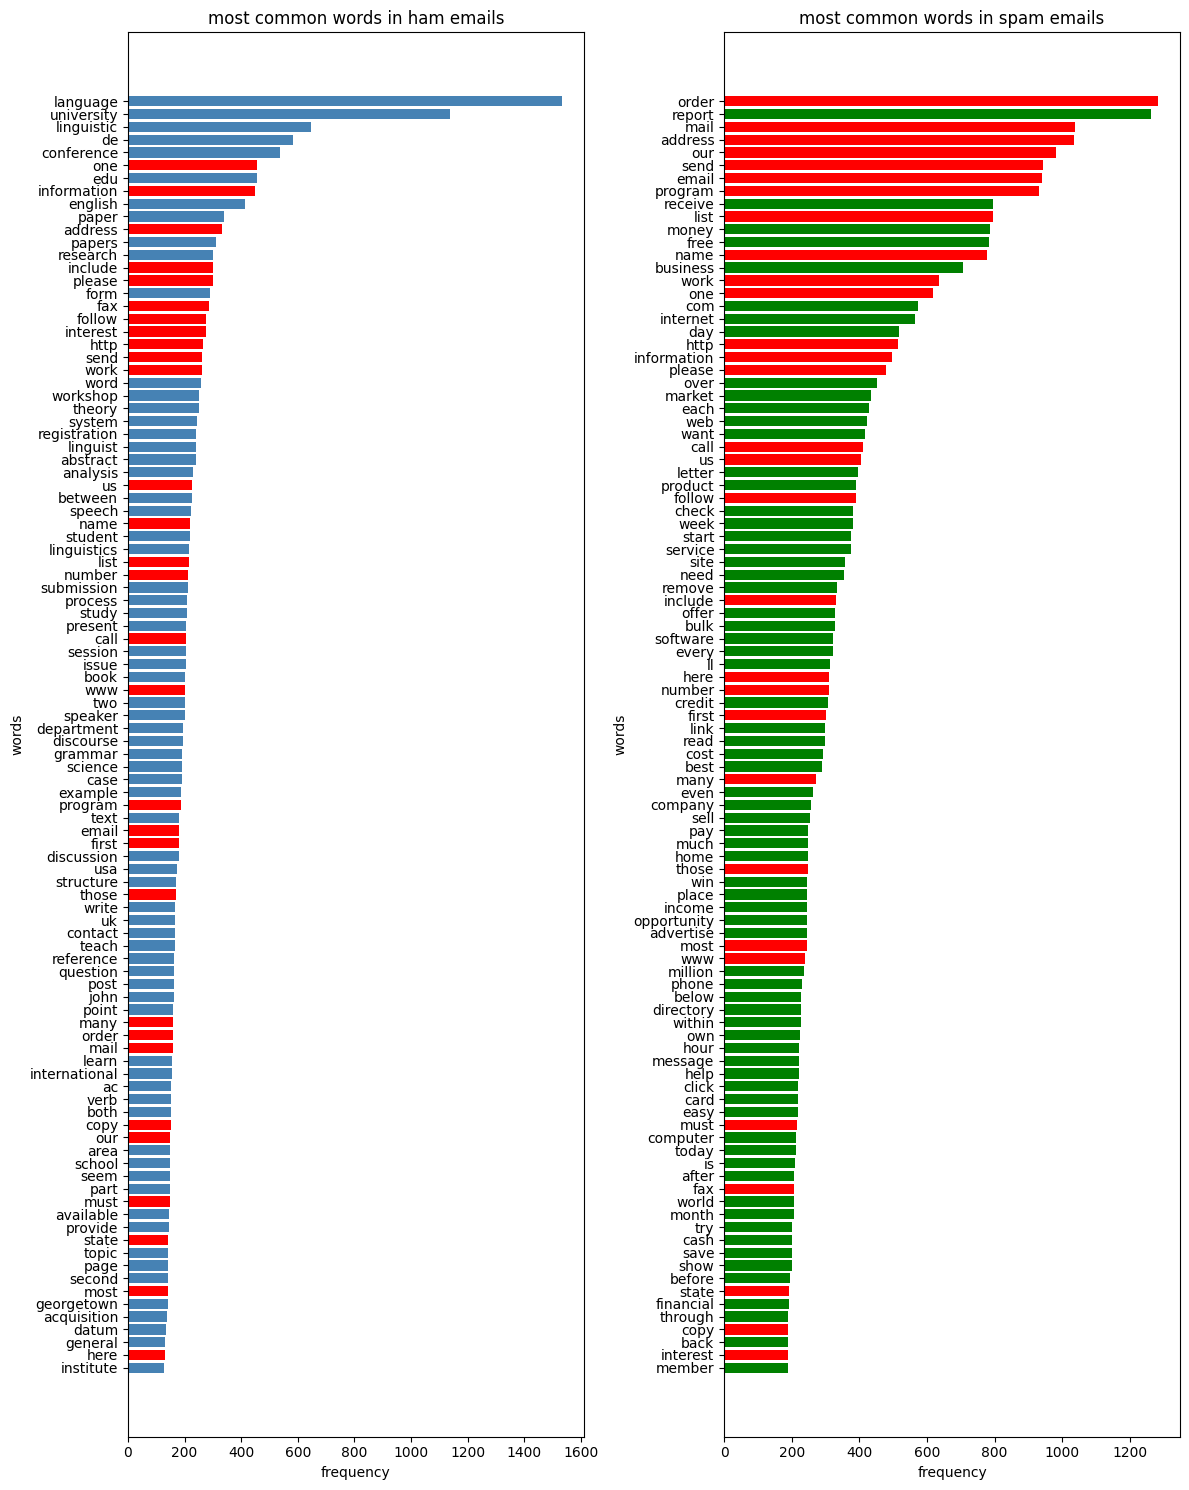

common words: ['address', 'call', 'copy', 'email', 'fax', 'first', 'follow', 'here', 'http', 'include', 'information', 'interest', 'list', 'mail', 'many', 'most', 'must', 'name', 'number', 'one', 'order', 'our', 'please', 'program', 'send', 'state', 'those', 'us', 'work', 'www']


In [14]:
import matplotlib.pyplot as plt

top_count = 100
plt.figure(figsize=(12, 15))

# filter out ham emails 
ham_emails = all_emails[all_emails['is_spam'] == 0]
text = ' '.join(ham_emails['contents'].tolist())
words = text.lower().split()
words = [word for word in words if word.isalpha() and len(word) > 1]

# sort ham email words
ham_wcs = {}
for word in words:
    if word in ham_wcs: ham_wcs[word] += 1
    else: ham_wcs[word] = 1

sorted_words = sorted(ham_wcs.items(), key=lambda x: x[1], reverse=True)
top_ham_words = sorted_words[:top_count]
ham_words = [word for word, count in top_ham_words] 
ham_counts = [count for word, count in top_ham_words]

# filter out spam emails 
spam_emails = all_emails[all_emails['is_spam'] == 1]
text = ' '.join(spam_emails['contents'].tolist())
words = text.lower().split()
words = [word for word in words if word.isalpha() and len(word) > 1]

# sort spam email words
spam_wcs = {}
for word in words:
    if word in spam_wcs: spam_wcs[word] += 1
    else: spam_wcs[word] = 1

sorted_words = sorted(spam_wcs.items(), key=lambda x: x[1], reverse=True)
top_spam_words = sorted_words[:top_count]
spam_words = [word for word, count in top_spam_words] 
spam_counts = [count for word, count in top_spam_words]

# check for common words
common_words = set(ham_words) & set(spam_words)

plt.subplot(1, 2, 1)
colors = ['red' if word in common_words else 'steelblue' for word in ham_words]
plt.barh(ham_words, ham_counts, color=colors)
plt.xlabel('frequency')
plt.ylabel('words')
plt.title('most common words in ham emails')
plt.gca().invert_yaxis()

plt.subplot(1, 2, 2)
colors = ['red' if word in common_words else 'green' for word in spam_words]
plt.barh(spam_words, spam_counts, color=colors)
plt.xlabel('frequency')
plt.ylabel('words')
plt.title('most common words in spam emails')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

print(f"common words: {sorted(common_words)}")

In [15]:
ham_wcs = sorted(ham_wcs.items(), key=lambda x: x[1], reverse=True)[:100]
print(ham_wcs)
spam_wcs = sorted(spam_wcs.items(), key=lambda x: x[1], reverse=True)[:100]
print(spam_wcs)

[('language', 1533), ('university', 1138), ('linguistic', 645), ('de', 583), ('conference', 538), ('one', 457), ('edu', 455), ('information', 449), ('english', 414), ('paper', 339), ('address', 332), ('papers', 310), ('research', 302), ('include', 300), ('please', 300), ('form', 291), ('fax', 285), ('follow', 277), ('interest', 275), ('http', 266), ('send', 263), ('work', 262), ('word', 257), ('workshop', 252), ('theory', 250), ('system', 244), ('registration', 241), ('linguist', 240), ('abstract', 240), ('analysis', 230), ('us', 228), ('between', 228), ('speech', 223), ('name', 221), ('student', 221), ('linguistics', 215), ('list', 214), ('number', 211), ('submission', 211), ('process', 210), ('study', 207), ('present', 206), ('call', 206), ('session', 205), ('issue', 205), ('book', 203), ('www', 203), ('two', 201), ('speaker', 200), ('department', 195), ('discourse', 194), ('grammar', 192), ('science', 191), ('case', 191), ('example', 189), ('program', 186), ('text', 182), ('email', 

In [16]:
def count_common_words(content, word_list):
    content_words = content.split()
    total = 0
    for word in content_words: 
        if word in word_list: total += 1
    return total 

In [17]:
print(all_emails.columns)

Index(['subject', 'contents', 'subj_len', 'body_len', 'is_spam', 'word_count',
       'avg_word_len'],
      dtype='object')


# !!! USE FAISS AND SENTENCE TRANSFORMER LIBRARIES !!! 

In [18]:
all_emails['ham_wc'] = all_emails['contents'].apply(count_common_words, args=(ham_words,))
all_emails['spam_wc'] = all_emails['contents'].apply(count_common_words, args=(spam_words,))

all_emails.to_csv('all_emails.csv', index=False)
all_emails.head()

,subject,contents,subj_len,body_len,is_spam,word_count,avg_word_len,ham_wc,spam_wc
0,wkshp : * early * - e ( = ) uralic interaction,organize combination colloquium work seminar p...,46,1917,0,340,4.64,26,21
1,job announcement - academium sinica,"job announcement institute history philology ,...",35,1339,0,223,5.01,31,15
2,knowledge language bibliography,association language awareness knowledge langu...,31,953,0,253,2.77,27,9
3,service update,due significant rapid policy change recently i...,14,311,1,54,4.78,8,15
4,job announcement,job announcement department foreign language l...,16,1218,0,204,4.98,26,15


# 4. Prepare the Data (APPROACH 1)


Apply any data transformations and explain what and why

In [19]:
all_emails['full_text'] = all_emails['subject'] + '\n' + all_emails['contents'] 

model = SentenceTransformer('all-MiniLM-L6-v2') 
embeddings = model.encode(all_emails['full_text'].tolist(),
                          show_progress_bar=True, 
                          batch_size=32)

print(f'embeddings shape: {embeddings.shape}')

Batches:   0%|          | 0/28 [00:00<?, ?it/s]

embeddings shape: (872, 384)


In [20]:
feats = all_emails[['subj_len', 'body_len', 'word_count', 
                    'avg_word_len', 'ham_wc', 'spam_wc']].values
y = all_emails['is_spam'].values

In [21]:
indices = np.arange(len(y))

indices1, i_test = train_test_split(
    indices, test_size=0.2, 
    random_state=42,
    stratify=y
)

i_train, i_val = train_test_split(
    indices1, 
    test_size=0.25,
    random_state=42,
    stratify=y[indices1]
)

print(f'train indices: {len(i_train)}')
print(f'test indices: {len(i_test)}')
print(f'val indices: {len(i_val)}')


train indices: 522
test indices: 175
val indices: 175


In [22]:
# scale pre-existing data (all_emails features) 
scaler = StandardScaler()

feats_train = scaler.fit_transform(feats[i_train])
feats_val = scaler.transform(feats[i_val])
feats_test = scaler.transform(feats[i_test])

# combine scaled feats and embeddings
X_train = np.concatenate([embeddings[i_train], feats_train], axis=1)
X_val = np.concatenate([embeddings[i_val], feats_val], axis=1)
X_test = np.concatenate([embeddings[i_test], feats_test], axis=1)

# labels
y_train = y[i_train]
y_val = y[i_val]
y_test = y[i_test]

# 5. Model the data (APPROACH 1)
Using selected ML models, experment with your choices and describe your findings. Finish by selecting a Model to continue with


In [23]:
# reshape everything into tensors!
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train).reshape(-1, 1)
train_ds = TensorDataset(X_train, y_train)

X_val = torch.FloatTensor(X_val)
y_val = torch.FloatTensor(y_val).reshape(-1, 1)
val_ds = TensorDataset(X_val, y_val)

X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test).reshape(-1, 1)
test_ds = TensorDataset(X_test, y_test)

# make dataloaders
train_loader = DataLoader(
    train_ds,
    batch_size=32,
    shuffle=True,
    num_workers=0
)

val_loader = DataLoader(
    val_ds,
    batch_size=32,
    shuffle=False,
    num_workers=0
)

test_loader = DataLoader(
    test_ds, 
    batch_size=32,
    shuffle=False,
    num_workers=0
)

In [24]:
class EmailClassifier(nn.Module):
    def __init__(self, input_size):
        super(EmailClassifier, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
        
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
        
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)

In [25]:
input_size = X_train.shape[1]
model = EmailClassifier(input_size) 

In [26]:
num_epochs = 50
crit = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(50):
    model.train()
    for feats, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(feats)
        loss = crit(outputs, labels)
        loss.backward()
        optimizer.step()

    model.eval()
    correct = 0; total = 0 
    with torch.no_grad():
        for feats, labels in val_loader:
            outputs = model(feats)
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    print(f'epoch {epoch+1}/50 -- val accuracy: {val_acc:.4f}')

epoch 1/50 -- val accuracy: 0.9714
epoch 2/50 -- val accuracy: 0.9771
epoch 3/50 -- val accuracy: 0.9771
epoch 4/50 -- val accuracy: 0.9771
epoch 5/50 -- val accuracy: 0.9771
epoch 6/50 -- val accuracy: 0.9771
epoch 7/50 -- val accuracy: 0.9829
epoch 8/50 -- val accuracy: 0.9829
epoch 9/50 -- val accuracy: 0.9829
epoch 10/50 -- val accuracy: 0.9829
epoch 11/50 -- val accuracy: 0.9886
epoch 12/50 -- val accuracy: 0.9886
epoch 13/50 -- val accuracy: 0.9886
epoch 14/50 -- val accuracy: 0.9886
epoch 15/50 -- val accuracy: 0.9886
epoch 16/50 -- val accuracy: 0.9886
epoch 17/50 -- val accuracy: 0.9886
epoch 18/50 -- val accuracy: 0.9886
epoch 19/50 -- val accuracy: 0.9886
epoch 20/50 -- val accuracy: 0.9886
epoch 21/50 -- val accuracy: 0.9886
epoch 22/50 -- val accuracy: 0.9886
epoch 23/50 -- val accuracy: 0.9886
epoch 24/50 -- val accuracy: 0.9886
epoch 25/50 -- val accuracy: 0.9886
epoch 26/50 -- val accuracy: 0.9886
epoch 27/50 -- val accuracy: 0.9886
epoch 28/50 -- val accuracy: 0.9886
e

In [27]:
model.eval()
all_preds = []
all_labels = [] 

with torch.no_grad():
    for feats, labels in test_loader:
        outputs = model(feats)
        preds = (outputs > 0.5).float()
        all_preds.append(preds)
        all_labels.append(labels)

all_preds = torch.cat(all_preds).numpy().flatten()
all_labels = torch.cat(all_labels).numpy().flatten()

test_acc = (all_preds == all_labels).mean()
print(f'test accuracy: {test_acc:.4f}')

test accuracy: 0.9600


In [28]:
torch.save(model, 'model1.pth')

# 4. Prepare the Data (APPROACH 2)


Apply any data transformations and explain what and why

In [29]:
# build a vocabulary from our database

def build_vocab(texts):
    word_freq = {}
    for text in texts:
        words = text.split()
        for word in words:
            if word in word_freq: word_freq[word] += 1
            else: word_freq[word] = 1

    words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

    word_to_idx = {'<PADDING>': 0, '<UNKNOWN>': 1}
    idx = 2

    for word, freq in words:
        if idx >= 5000: # set 5000 as the upper limit; likely no more than 5000 unique words
            break
        word_to_idx[word] = idx
        idx += 1

    return word_to_idx

In [30]:
train_texts = all_emails['full_text'].iloc[i_train] 
word2idx = build_vocab(train_texts)

In [31]:
# convert text to sequences 

def text_to_seq(text, word2idx, max_len):
    seq = []
    for word in text.split():
        if word in word2idx: seq.append(word2idx[word])
        else: seq.append(1)

    if len(seq) < max_len:
        seq += [0] * (max_len - len(seq))
    else: seq = seq[:max_len]

    return seq 

In [32]:
X = np.array(
    [text_to_seq(text, word2idx, 200) 
     for text in all_emails['full_text']]
)

In [33]:
X_train = X[i_train]; X_test = X[i_test]; X_val = X[i_val]; 

y_train = y[i_train]; y_test = y[i_test]; y_val = y[i_val]; 

In [34]:
# convert to tensors 

X_train = torch.LongTensor(X_train)
y_train = torch.FloatTensor(y_train).reshape(-1, 1)

X_test = torch.LongTensor(X_test)
y_test = torch.FloatTensor(y_test).reshape(-1, 1)

X_val = torch.LongTensor(X_val)
y_val = torch.FloatTensor(y_val).reshape(-1, 1)

# create dataloaders
train_loader = DataLoader(
    TensorDataset(X_train, y_train),
    batch_size=32,
    shuffle=True,
    num_workers=0
)

test_loader = DataLoader(
    TensorDataset(X_test, y_test),
    batch_size=32,
    shuffle=False,
    num_workers=0
)

val_loader = DataLoader(
    TensorDataset(X_val, y_val),
    batch_size=32,
    shuffle=False,
    num_workers=0
)

# 5. Model the data (APPROACH 2)
Using selected ML models, experment with your choices and describe your findings. Finish by selecting a Model to continue with


In [35]:
class EmailClassifier2(nn.Module):
    def __init__(self, vocab_size):
        super(EmailClassifier2, self).__init__()
        self.embedding = nn.Embedding(vocab_size, 128, padding_idx=0)
        self.lstm = nn.LSTM(128, 64, batch_first=True)
        self.fc = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid() 

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        x = self.fc(hidden[-1])
        return self.sigmoid(x)

model2 = EmailClassifier2(len(word2idx))
print(model2)

EmailClassifier2(
  (embedding): Embedding(5000, 128, padding_idx=0)
  (lstm): LSTM(128, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [36]:
crit = nn.BCELoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)

for epoch in range(50):
    model2.train()
    for seqs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model2(seqs)
        loss = crit(outputs, labels)
        loss.backward()
        optimizer.step()

    model2.eval()
    correct = 0; total = 0; 

    with torch.no_grad():
        for seqs, labels in val_loader:
            outputs = model2(seqs)
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct/total
    print(f'epoch {epoch+1}/50: val accuracy: {val_acc:.4f}')

epoch 1/50: val accuracy: 0.6000
epoch 2/50: val accuracy: 0.6171
epoch 3/50: val accuracy: 0.6286
epoch 4/50: val accuracy: 0.6343
epoch 5/50: val accuracy: 0.8514
epoch 6/50: val accuracy: 0.8514
epoch 7/50: val accuracy: 0.8457
epoch 8/50: val accuracy: 0.8400
epoch 9/50: val accuracy: 0.8629
epoch 10/50: val accuracy: 0.8400
epoch 11/50: val accuracy: 0.8857
epoch 12/50: val accuracy: 0.8571
epoch 13/50: val accuracy: 0.8800
epoch 14/50: val accuracy: 0.8629
epoch 15/50: val accuracy: 0.8629
epoch 16/50: val accuracy: 0.8686
epoch 17/50: val accuracy: 0.8686
epoch 18/50: val accuracy: 0.8686
epoch 19/50: val accuracy: 0.8743
epoch 20/50: val accuracy: 0.8743
epoch 21/50: val accuracy: 0.8686
epoch 22/50: val accuracy: 0.8686
epoch 23/50: val accuracy: 0.8629
epoch 24/50: val accuracy: 0.8686
epoch 25/50: val accuracy: 0.6400
epoch 26/50: val accuracy: 0.8457
epoch 27/50: val accuracy: 0.8629
epoch 28/50: val accuracy: 0.8800
epoch 29/50: val accuracy: 0.8800
epoch 30/50: val accura

In [37]:
model2.eval()
preds_l = []
labels_l = []

with torch.no_grad():
    for seqs, labels in test_loader:
        outputs = model2(seqs)
        preds = (outputs > 0.5).float()
        preds_l.append(preds); labels_l.append(labels)

preds = torch.cat(preds_l).numpy().flatten()
labels = torch.cat(labels_l).numpy().flatten()

test_acc = (preds == labels).mean()
print(f'test accuracy: {test_acc:.4f}')

test accuracy: 0.9314


In [38]:
torch.save(model2, 'model2.pth')

# 6. Fine Tune the Model

With the select model descibe the steps taken to acheve the best rusults possiable 


In [39]:
class tuning_model2(nn.Module):
    def __init__(self, 
                 vocab_size, 
                 embedding_dim=128,
                 hidden_dim=64, 
                 num_layers=1, 
                 dropout=0.3, 
                 bidirectional=False):
        super(tuning_model2, self).__init__()
    
        self.embedding = nn.Embedding(
            vocab_size,
            embedding_dim, 
            padding_idx=0
        )
        self.lstm = nn.LSTM(
            embedding_dim, 
            hidden_dim, 
            num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional = bidirectional
        )
    
        self.dropout = nn.Dropout(dropout)
        output_size = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc = nn.Linear(output_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)

        if self.lstm.bidirectional:
            hidden = torch.cat([hidden[-2], hidden[-1]], dim=1)
        else: hidden = hidden[-1]

        hidden = self.dropout(hidden)
        return self.sigmoid(self.fc(hidden))
    

In [ ]:
param_space = {
    'embedding_dim': [64, 128, 256, 512],
    'hidden_dim': [32, 64, 128],
    'num_layers': [1, 2, 3],
    'dropout': [0.2, 0.3, 0.4, 0.5],
    'lr': [0.0001, 0.001, 0.01],
    'batch_size': [16, 32, 64],
    'bidirectional': [True, False]
}

n = 15
results = []

for trial in range(15):
    params = {key: random.choice(values) for key, values in param_space.items()}

    print(f'trial {trial+1}/15')
    print(f'params: {params}')
    
    test_model = tuning_model2(
        vocab_size=len(word2idx),
        embedding_dim=params['embedding_dim'],
        hidden_dim=params['hidden_dim'],
        num_layers=params['num_layers'],
        dropout=params['dropout'],
        bidirectional=params['bidirectional']
    )

    crit = nn.BCELoss()
    optimizer = optim.Adam(test_model.parameters(), lr=params['lr'])

    best_val_acc = 0
    for epoch in range(25): 
        test_model.train()
        for seqs, labels in train_loader:
            optimizer.zero_grad()
            outputs = test_model(seqs)
            loss = crit(outputs, labels)
            loss.backward()
            optimizer.step()
        
        test_model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for seqs, labels in val_loader:
                outputs = test_model(seqs)
                preds = (outputs > 0.5).float()
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        
        val_acc = correct / total
        if val_acc > best_val_acc:
            best_val_acc = val_acc
    
    results.append({**params, 'val_accuracy': best_val_acc})
    print(f'best val accuracy: {best_val_acc:.4f}\n')

# find best parameters
results_df = pd.DataFrame(results).sort_values('val_accuracy', ascending=False)
best_params = results_df.iloc[0].to_dict()


trial 1/15
params: {'embedding_dim': 512, 'hidden_dim': 64, 'num_layers': 1, 'dropout': 0.4, 'lr': 0.001, 'batch_size': 32, 'bidirectional': True}
best val accuracy: 0.9829

trial 2/15
params: {'embedding_dim': 512, 'hidden_dim': 32, 'num_layers': 2, 'dropout': 0.2, 'lr': 0.0001, 'batch_size': 64, 'bidirectional': False}
best val accuracy: 0.7257

trial 3/15
params: {'embedding_dim': 64, 'hidden_dim': 32, 'num_layers': 3, 'dropout': 0.2, 'lr': 0.01, 'batch_size': 64, 'bidirectional': True}
best val accuracy: 0.9200

trial 4/15
params: {'embedding_dim': 512, 'hidden_dim': 64, 'num_layers': 2, 'dropout': 0.3, 'lr': 0.001, 'batch_size': 32, 'bidirectional': False}
best val accuracy: 0.9257

trial 5/15
params: {'embedding_dim': 512, 'hidden_dim': 32, 'num_layers': 1, 'dropout': 0.3, 'lr': 0.01, 'batch_size': 16, 'bidirectional': False}
best val accuracy: 0.7029

trial 6/15
params: {'embedding_dim': 256, 'hidden_dim': 64, 'num_layers': 2, 'dropout': 0.5, 'lr': 0.0001, 'batch_size': 32, 'bid

# 7. Present
In a customer faceing Document provide summery of finding and detail approach taken

There were 2 approaches I took to classifying spam/ham emails:

### approach 1: using sentencetransformer embeddings and sequential neural network (model1.pth)
this involved using the sentencetransformer library -- which converted text to embeddings that had semantic meanings, via a pre-trained model -- which would convert email contents to numerical data. this, combined with other features (like subj_len, word_count, ham_wc, etc.), would all go into a neural network. 
some problems included:
- although i was told we were allowed to use the sentencetransformer library, i wasn't sure if we were alowed to use the embeddings feature since this consisted of a pre-trained model
- with this model, i started with really high validation accuracies (~85%), which would quickly plateau at around ~30 epochs with accuracies of 99.24
    - i worried that this would be overfitting; however, this model yielded test accuracies of ~95%, which isn't too far off
    - hence, i think the sentencetransformer library's pre-trained model was just highly effective in deciphering semantic meaning within emails
    - after testing for data leakage and confirming that there was not any, this conclusion was further solidified

### approach 2: using manual vocabulary building and lstm (model2.pth)
because i worried that model1 would not follow the specifications for the project, i included a different approach that involved building a manual vocabulary from assigning a unique index to each word in the training dataset (as well as including \<PADDING> and \<UNKNOWN> to account for shorter emails + words not present in training that are present in test/val datasets), then fed only that numerical data into an lstm  
- this was a more straightforward approach, without having to depend on pre-trained models
- with this model, i started with much lower validation accuracies (~60%), which steadily increased to ~91% by the 50th epoch.
    - this is considerably lower compared to model1, especially since model1 reached ~91% validation accuracy by the 30th epoch in training
    - however, model2's test accuracy wasn't much lower (~93%), which indicates a similar final performance when it came to unseen data
    - in this method, i didn't pass the other engineered features (subj_len, word_count, etc.) -- nonetheless, it yielded high accuracies

# 8. Launch the Model System
Define your production run code, This should be self susficent and require only your model pramaters 


In [ ]:
def inference(filepath):
    if os.path.isfile(filepath):
        with open(filepath, 'r', encoding='utf-8') as file:
            contents = file.read() 
            text_list = contents.split('\n')
            text_list = [x for x in text_list if x]

            # extract subject line and email content 
            subj_line = text_list[0][9:] 
            email_cont = text_list[1] 
            is_spam = 1 if 'spm' in filename else 0



In [4]:
import zipfile

zip_filename = "email_archive.zip"
extract_dir = "og_emails"

with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)